# Sparse Spiking Ensemble

- Ensemble = Sensory neurons + latent neurons
- Sensory neurons get spikes from sensory inputs
- Sensory inputs are sparse coded (~20% 1s, rest 0s)
- Each neuron also takes input from the whole ensemble (later to be restricted locally)

## New in this notebook
- Show many input patterns

## Results
- Network learns disentangled representations for each pattern!

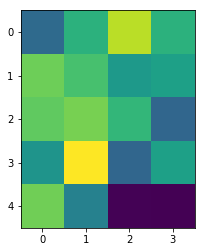

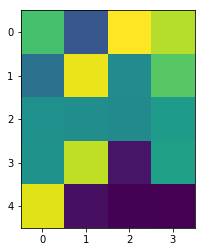

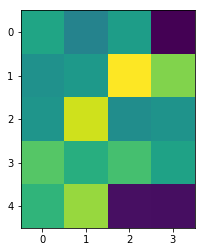

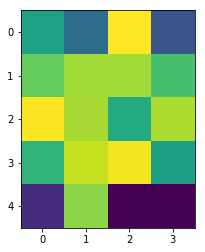

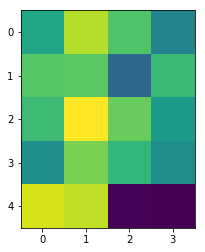

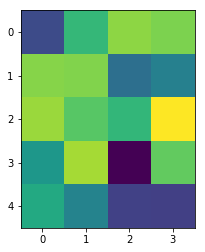

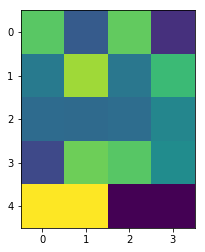

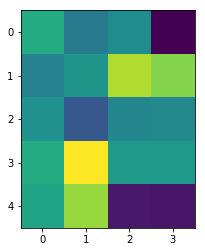

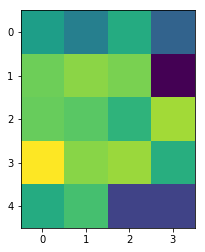

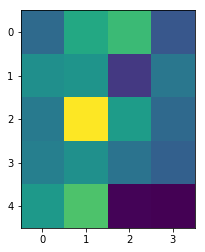

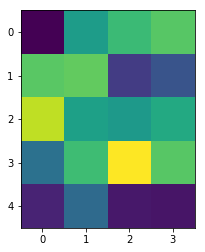

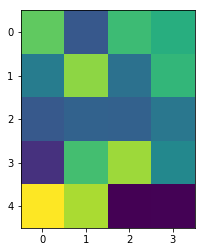

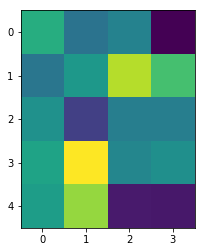

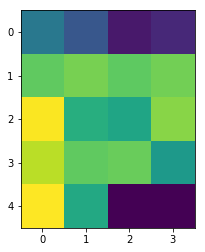

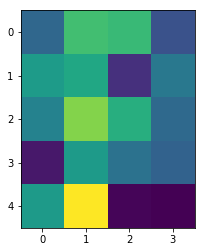

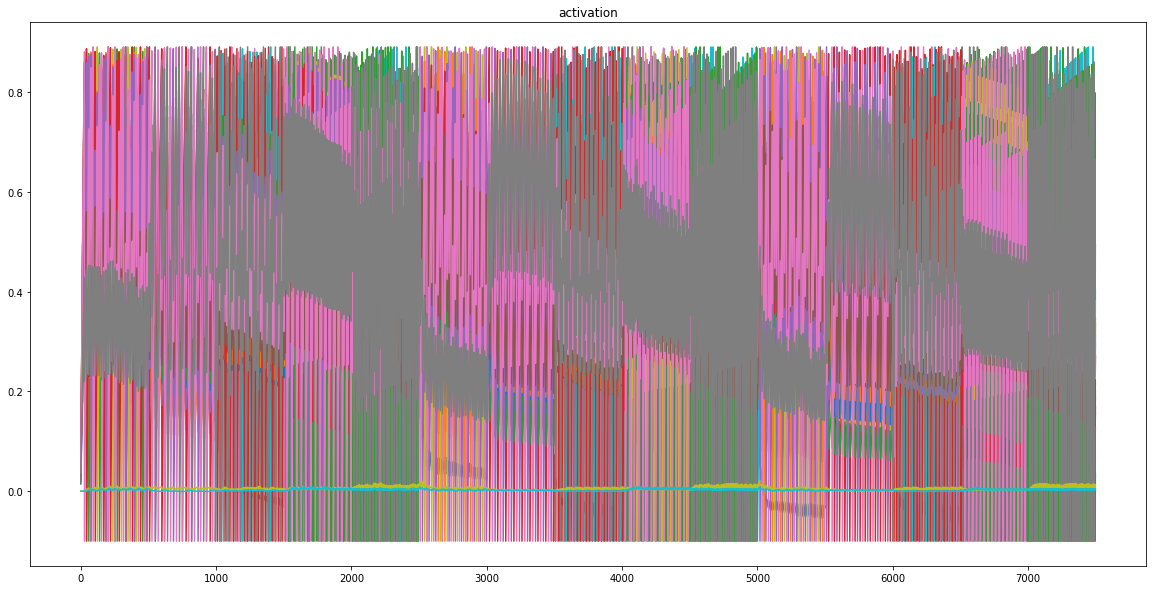

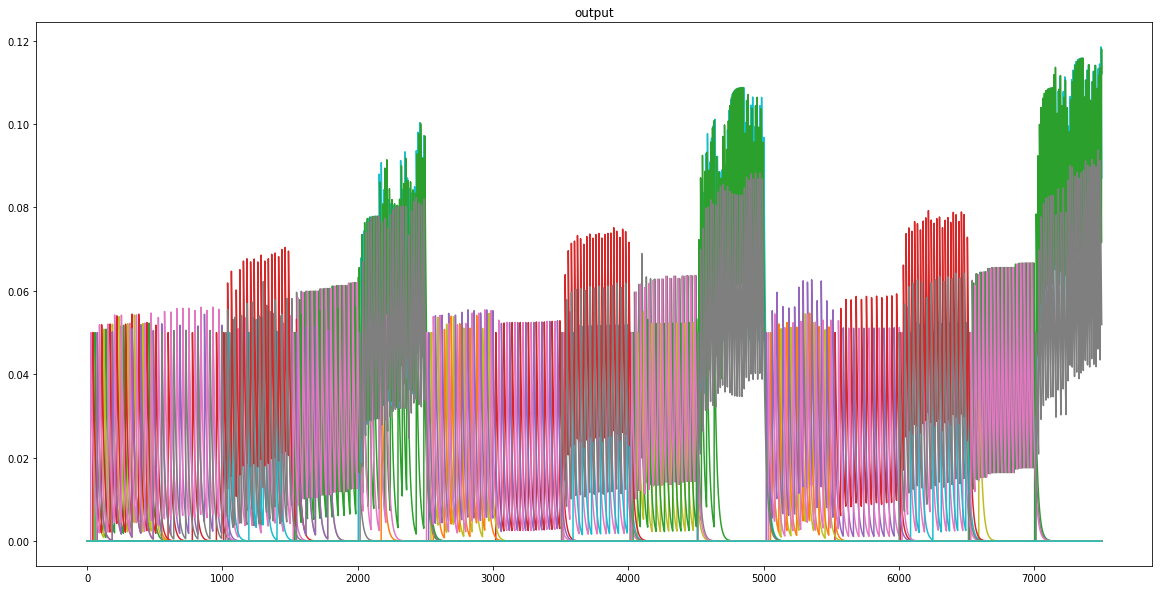

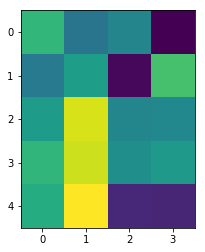

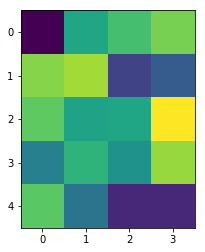

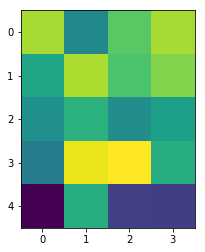

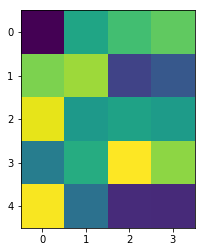

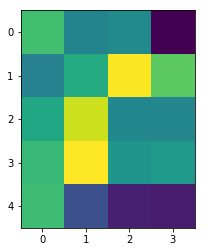

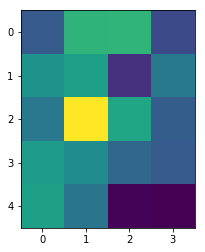

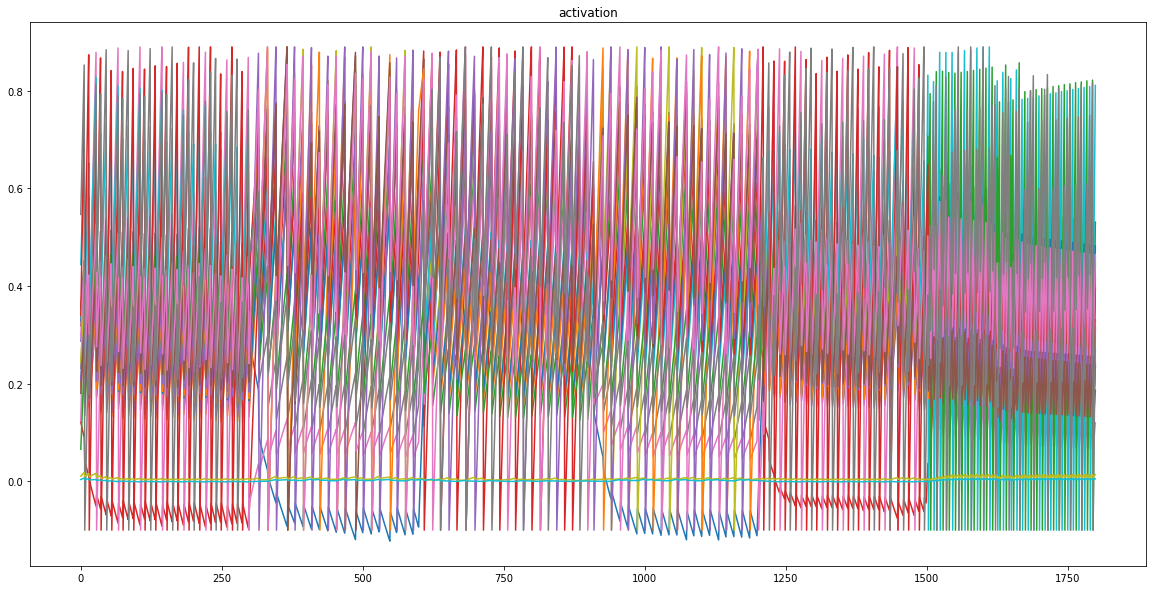

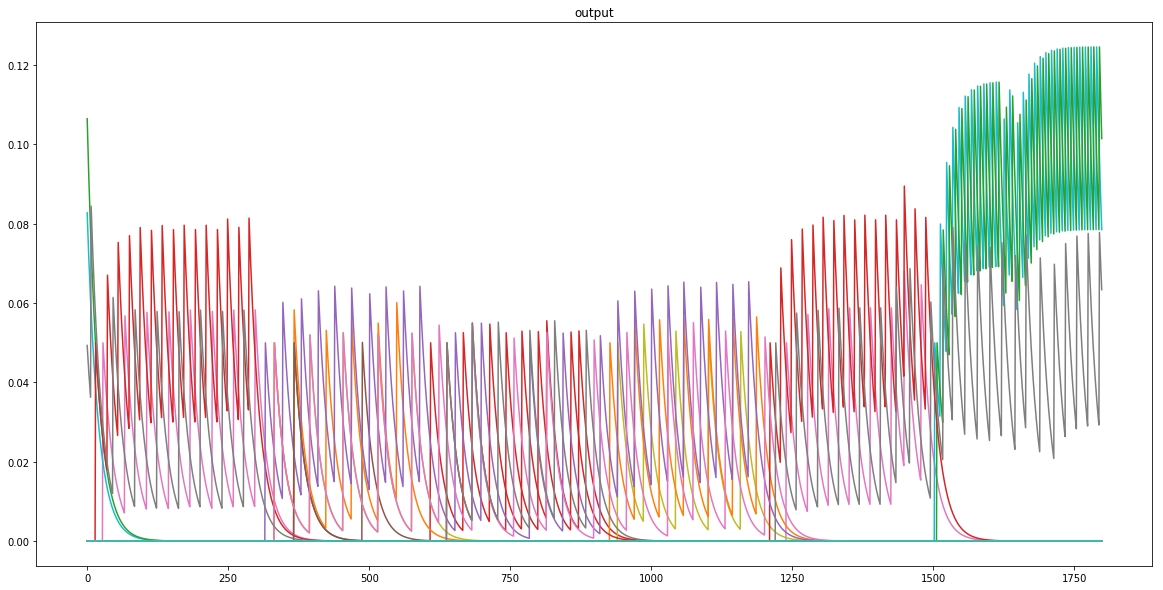

In [47]:
from collections import defaultdict
import torch
import matplotlib.pyplot as plt

SENSORY_MODALITY_1_WIDTH = 10
SENSORY_MODALITY_1_HEIGHT = 10
SENSORY_MODALITY_1_SIZE = SENSORY_MODALITY_1_WIDTH * SENSORY_MODALITY_1_HEIGHT

SENSORY_MODALITY_1_NEURONS = 18
LATENT_NEURONS = 2

SPARSITY = 0.1
NEGATIVE_WEIGHT = 0.2

ENSEMBLE_NEURONS = SENSORY_MODALITY_1_NEURONS + LATENT_NEURONS
ENSEMBLE_WIDTH = 4
ENSEMBLE_HEIGHT = 5
assert(ENSEMBLE_WIDTH * ENSEMBLE_HEIGHT == ENSEMBLE_NEURONS)

def make_sparse_embedding(size):
  return (torch.FloatTensor(size).uniform_() < SPARSITY).long().float()

MODALITY_1_SYMBOLS = {
    '0': make_sparse_embedding(SENSORY_MODALITY_1_SIZE) * 0.0,
    'A': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'B': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'C': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'D': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
    'E': make_sparse_embedding(SENSORY_MODALITY_1_SIZE),
}

V_THRESHOLD = 0.9
V_ZERO = 0
V_RESET = -0.2

class Network:
  def __init__(self):
    self.activation = torch.zeros(ENSEMBLE_NEURONS)
    self.output = torch.zeros(ENSEMBLE_NEURONS)

    self.afferent_weights = torch.zeros((SENSORY_MODALITY_1_NEURONS, SENSORY_MODALITY_1_SIZE)).uniform_() - NEGATIVE_WEIGHT  # weights [-NEGATIVE_WEIGHT, 1-NEGATIVE_WEIGHT], e.g. [-0.2, 0.8]
    #self.afferent_weights = torch.ones((SENSORY_MODALITY_1_NEURONS, SENSORY_MODALITY_1_SIZE)) - NEGATIVE_WEIGHT  # weights [-NEGATIVE_WEIGHT, 1-NEGATIVE_WEIGHT], e.g. [-0.2, 0.8]
    #self.afferent_weights[0] -= 0.1
    # print("self.afferent_weights", self.afferent_weights)
    
    self.lateral_weights  = torch.zeros((ENSEMBLE_NEURONS, ENSEMBLE_NEURONS)).uniform_() - NEGATIVE_WEIGHT

    self.lateral_weights[torch.eye(ENSEMBLE_NEURONS).byte()] = 0

    self.afferent_trace = torch.zeros((SENSORY_MODALITY_1_SIZE,))
    self.lateral_trace = torch.zeros((ENSEMBLE_NEURONS,))
    self.learning_rate = 0.01
    self.lateral_inhibition = 1 / ENSEMBLE_NEURONS
    self.trace_alpha = 0.05
    self.activation_alpha = 1.0 / SENSORY_MODALITY_1_SIZE
    self.activiation_decay = 0.0001
    
    self.captured_attributes = ['activation', 'output']
    self.figsize = (20, 10)
    self.reset_history()

  def reset_history(self):
    self.history = defaultdict(lambda: [])

  def capture_history(self):
    for attr_name in self.captured_attributes:
      self.history[attr_name].append(getattr(self, attr_name).clone())

  def report(self):
    for attr_name in self.captured_attributes:
      data = torch.stack(self.history[attr_name]).numpy()
      plt.figure(figsize=self.figsize)
      plt.plot(data)
      plt.title(attr_name)
      plt.show()

  def plot_activation(self):
    plt.imshow(self.activation.view((ENSEMBLE_HEIGHT, ENSEMBLE_WIDTH)).numpy())
    plt.show()

  def plot_output(self):
    plt.imshow(self.output.view((ENSEMBLE_HEIGHT, ENSEMBLE_WIDTH)).numpy())
    plt.show()

  def present_input(self, sensory_input):
    # Decay activation
    self.activation *= (1.0 - self.activiation_decay)
    # print("self.activation after decay", self.activation)

    # Sensory inputs and trace
    weighted_input = self.afferent_weights * sensory_input
    self.afferent_trace = self.afferent_trace * (1 - self.trace_alpha) + sensory_input * self.trace_alpha   # NOTE: Trace of inputs before applying weights
    weighted_input = weighted_input.sum(dim=1)
    # print("weighted_input", weighted_input)
    # print("self.afferent_trace", self.afferent_trace)

    # Lateral inputs (i.e. previous output) and trace
    weighted_lateral_input = self.lateral_weights * self.output
    self.lateral_trace = self.lateral_trace * (1 - self.trace_alpha) + self.output * self.trace_alpha      # NOTE: Trace of lateral inputs before applying weights
    weighted_lateral_input = weighted_lateral_input.sum(dim=1)
    # print("weighted_lateral_input", weighted_lateral_input)
    # print("self.lateral_trace", self.lateral_trace)

    # Total input
    total_input = weighted_lateral_input
    total_input[0:SENSORY_MODALITY_1_NEURONS] += weighted_input
    # print("total_input", total_input)

    # Add input to activation
    self.activation = self.activation * (1 - self.activation_alpha) + total_input * self.activation_alpha
    # print("self.activation 1", self.activation)

    # Fire!
    active = (self.activation > V_THRESHOLD)
    self.activation[active] = V_RESET
    # print("Firing", active)

    # Currently active
    self.output = self.output * (1 - self.trace_alpha) + active.float() * self.trace_alpha

    # print("self.afferent_weights", self.afferent_weights)
    # Learning
    fired_indices = active.nonzero()
    if fired_indices.nelement() > 0:
      # print("self.afferent_trace", self.afferent_trace)
      for i in fired_indices:
        fired_index = i.item()

        # print("=========================")
        # print("Fired", fired_index)

        # afferent connections
        dist_from_trace = self.afferent_trace - self.afferent_weights
        # print("dist_from_trace[fired_index]", dist_from_trace[fired_index])
        dw_afferent_self = self.learning_rate * dist_from_trace[fired_index]
        # print("dw_afferent_self", dw_afferent_self)
        # print("self.afferent_weights[fired_index] before", self.afferent_weights[fired_index])
        self_afferent_weights = self.afferent_weights[fired_index].clone()
        self_afferent_weights += dw_afferent_self
        # print("self.afferent_weights[fired_index] after", self_afferent_weights)

        # Lateral inhibition
        min_dist = 0.01
        dist_from_trace[dist_from_trace.abs() < min_dist] = min_dist * dist_from_trace[dist_from_trace.abs() < min_dist].sign() # prep for division
        dw_afferent_neighbor = - self.learning_rate * self.lateral_inhibition * (1 / dist_from_trace) * (1 - self.afferent_weights.abs())
        # print("dw_afferent_neighbor", dw_afferent_neighbor)
        self.afferent_weights += dw_afferent_neighbor

        # Actually set self afferent weights here to prevent self-inhibition
        self.afferent_weights[fired_index] = self_afferent_weights

      # print("self.afferent_weights", self.afferent_weights)

      self.activation *= 0.5

    # Keep activation within bounds
    torch.clamp(self.activation, V_RESET, V_THRESHOLD - 0.01, out=self.activation)
    # self.activation[self.activation < V_RESET] = V_RESET
    # self.activation[self.activation > V_MAX] = V_MAX
    # print("self.activation clamped", self.activation)
    self.capture_history()

# print(MODALITY_1_SYMBOLS['A'])
network = Network()
for _ in range(3):
  for symbol in ['A', 'B', 'C', 'D', 'E']:
    for i in range(500):
      network.present_input(MODALITY_1_SYMBOLS[symbol])
    network.plot_activation()

network.report()
network.reset_history()
for i in range(300):
  network.present_input(MODALITY_1_SYMBOLS['C'])
network.plot_activation()
for i in range(300):
  network.present_input(MODALITY_1_SYMBOLS['A'])
network.plot_activation()
for i in range(300):
  network.present_input(MODALITY_1_SYMBOLS['C'] * 0.25 + MODALITY_1_SYMBOLS['B'])
network.plot_activation()
for i in range(300):
  network.present_input(MODALITY_1_SYMBOLS['A'])
network.plot_activation()
for i in range(300):
  network.present_input(MODALITY_1_SYMBOLS['C'])
network.plot_activation()
for i in range(300):
  network.present_input(MODALITY_1_SYMBOLS['E'])
network.plot_activation()

network.report()


## Notes
- In the first set of 2 line charts, look at the second chart. It shows neurons that fired for patterns A, B, C, D, E in sequence three times. For example, E shows up as red and light green.
- In the last line chart in the output, we can see neurons firing for C, A, C*0.25+B, A, C, E.
- C, A and E show up as same set of neurons (colors) as the previous chart. Especially E still uses the same neurons even after not being shown for a long time. The networks seems less succeptible to catastrophic forgetting - needs to be investigated further.
- C*0.25+B seems to fire B's neurons. This could mean that the network can tolerate noise.

## Sparser version of A

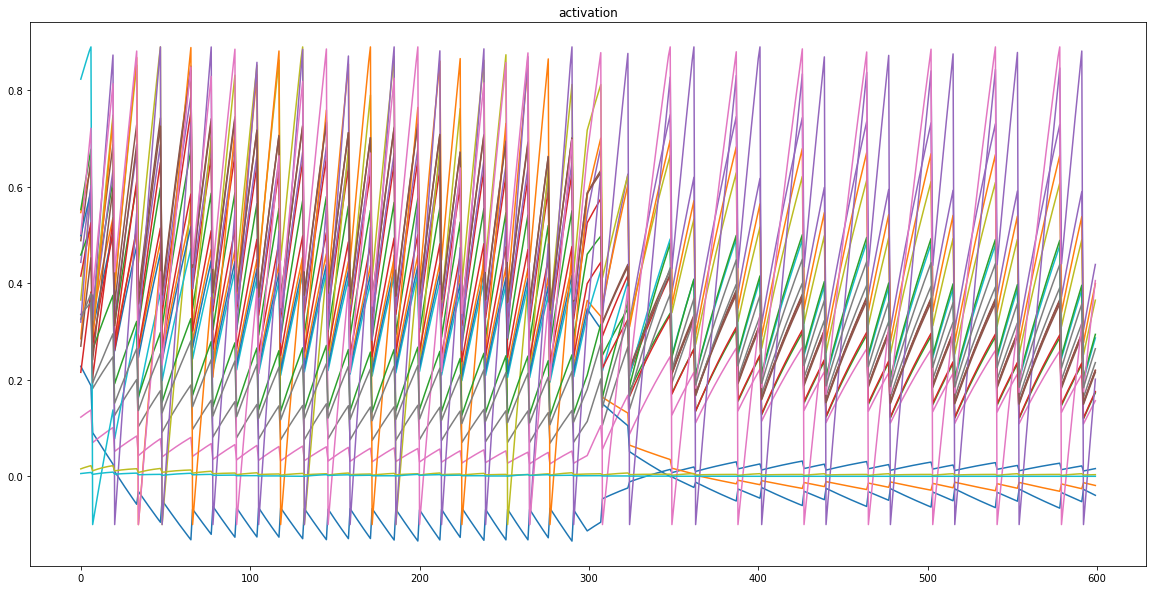

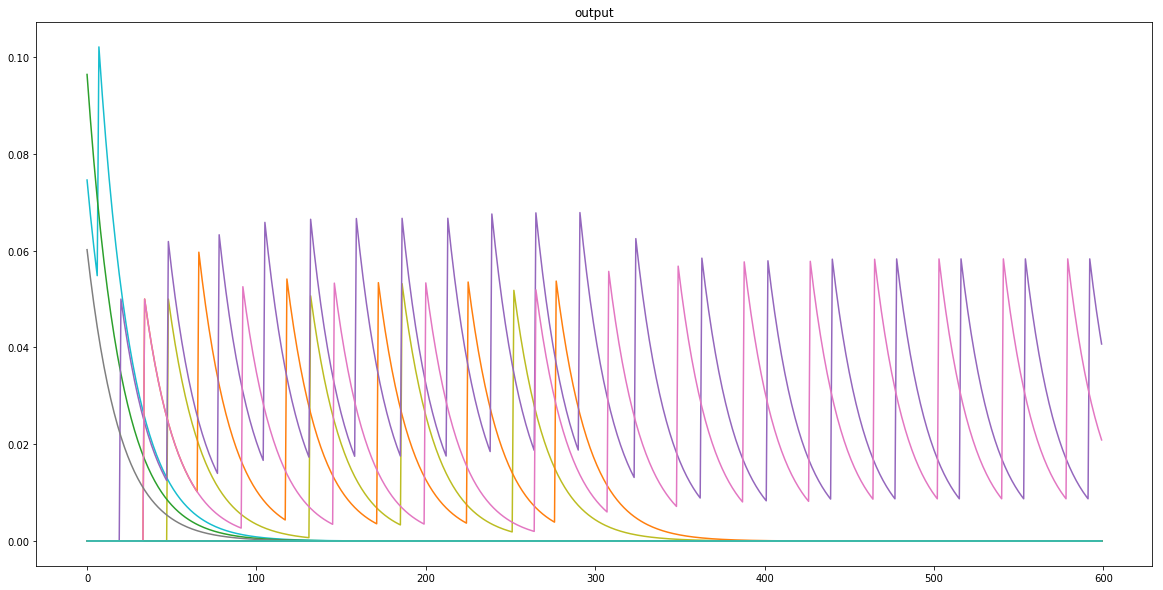

In [48]:
# Make an even sparser version of A that has half bits turned off
sparser_A = MODALITY_1_SYMBOLS['A'].clone()
mask = torch.FloatTensor(SENSORY_MODALITY_1_SIZE).uniform_() > 0.5
sparser_A[mask] = 0

network.reset_history()

for i in range(300):
  network.present_input(MODALITY_1_SYMBOLS['A'])
for i in range(300):
  network.present_input(sparser_A)
network.report()


When normal A is presented, we see purple, pink, yellow and orange. When a sparser version of A is presented, we get only purple and pink. A downstream classifier neuron would still be able to identify it as an A. It would also have lower spike frequency (2 instead of 4 neurons feeding it), indicating a lower confidence.

## Noisy version of B

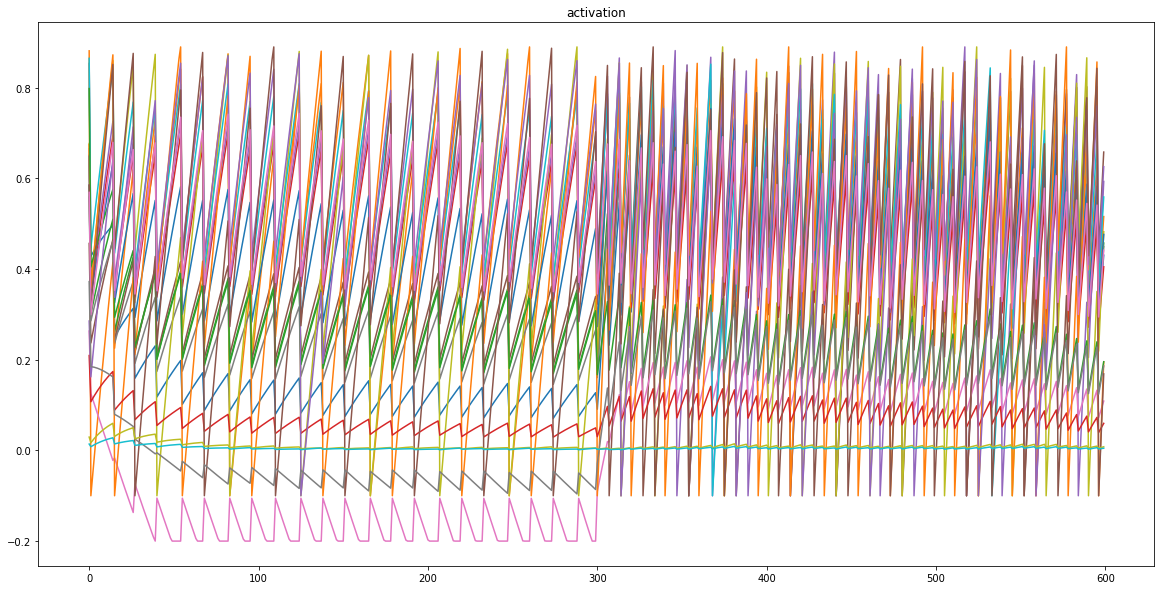

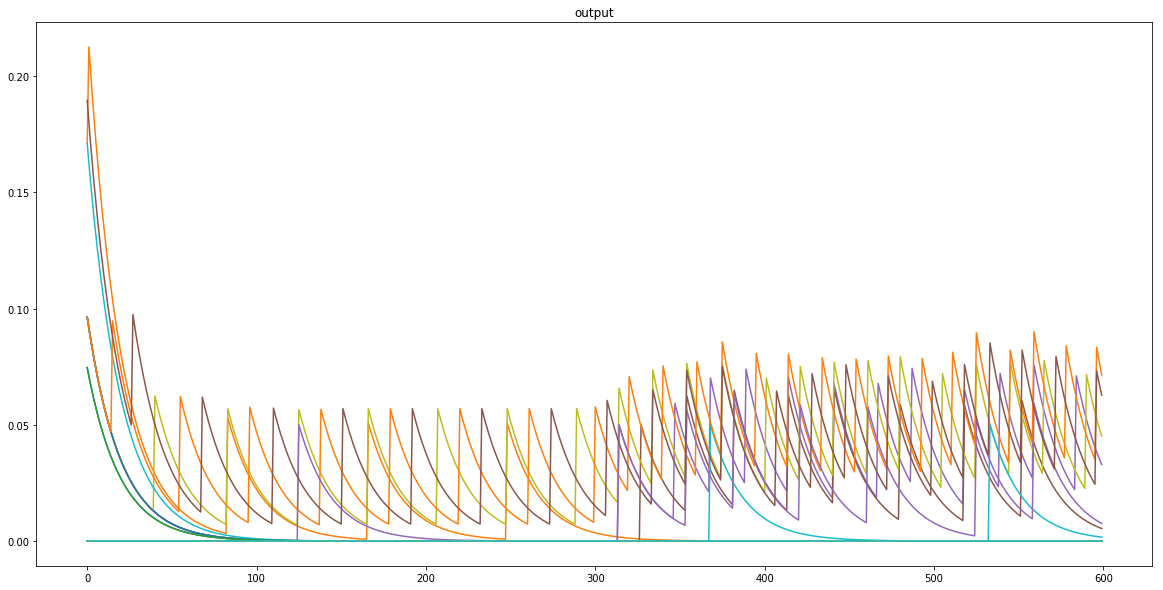

In [50]:
noisy_A = MODALITY_1_SYMBOLS['A'].clone()
mask = torch.FloatTensor(SENSORY_MODALITY_1_SIZE).uniform_() < 0.1 # At 20% sparsity, 10% noisy bits is 50% noise
noisy_A[mask] = 1

network.reset_history()

for i in range(300):
  network.present_input(MODALITY_1_SYMBOLS['A'])
for i in range(300):
  network.present_input(noisy_A)
network.report()


Notice that even at 50% noise bits added to A, same set of neurons fire. There are a few additional neurons firing (e.g. purple, light blue). A downstream classifier neuron would get excited due to A neurons and might get laterally inhibited by other neurons if they respond to the additional fired neurons. The result would again be lower firing rate for the classifier, indicating lower confidence.